What I want the data to look like 

8 mice
2 conditions
2 states per condition: sedentary and running
100 trials per condition


results are z-scores that range from -3.5 to 3.5 (using the same range as other paper) 

M1 activity primarily modulated by running onset. see similar increases in activity in both conditions. low activity in sendentary state
Amygdala: most cells have higher firing activity during sendentary phase of stress condition compared to sedentary phase of spontaneous running. See big spike in activity at stimulus onset

VTA: relatively slow ramp up in activity preceding spontaneous running onset, whereas rapid spike at or after escape onset 
    - these might be different neuron populations 



want the firing rates to be modulated by my eight factors (i.e cells would fall into one of those groups, and different regiosns would have different proportions of cells within the groups) 





0.64 ± 0.32 neurons per recording site on average
384 channels (aka sites to record from)
10 mm long probe
960 recording sites for 1.0
1250 recording sites for 2.0 probe per shank 
2.0 4 shank spans 0.7 mm



dentate nucleus: 0.8 mm DV

amygdala: ~1.2mm AP, 0.9 mm DV  

M1: 1.3 mm ML, 0.4DV

Going through FF and VTA at an angle with the same probe would cover 2.55 mm. Just gonna say divide the units 50/50


assumptions to make 
- for simplicity, going to assume all regions have equal cell density (very much not true, especially in cortex)

using this atlas to estimate 

In [514]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d


# Functions

In [515]:
def sites_per_ROI (probe = 1, height = None, length = None):
    ''' height:DV distance, length: AP distance, diagonal, or ML distance'''
    if probe == 1:
        if height == None:
            return("provide height")
        density = 96 #units per mm 
        sites = height*density

    elif probe ==2:
        density = 125
        if length == None:
            return("provide length")
        elif length< 0.7:
            return("ROI length shorter than 4 shank span")
        sites = height*density*4 #because four shanks 
        if sites>384:
            sites = 384
    
    return(sites)
    

In [516]:
def dataframe_to_dict(df):
    return {col: df[col].tolist() for col in df.columns}

old
def generate_neuron_activity(pre_stim, post_stim, num_cells, mod_prop):
    ''' pre_stim: number of points pre-stim
        post_stim: number of points post stim
        num_cells: the number of cells to generate the time series for 
        mod_prob: the proportion of the cells that show change in activity in response to the stimulus'''
    
    # Generate baseline activity (random z-scores) for all cells 
    baseline_activity_large = np.random.uniform(-3.5, 0.5, num_cells*(pre_stim + post_stim))
    
    baseline_activity = np.array(np.split(baseline_activity_large, num_cells))

    mod_cells = round(np.random.normal(mod_prop, .05)*num_cells) #the number of cells modulated by the task with 5% of the chosen percentage

    mod_cells_baseline = baseline_activity[:mod_cells+1]
    
    # Ramp-up before stimulus (increase activity toward peak at or just before stimulus)
    ramp_up = np.linspace(0, 3, pre_stim)  # Linear ramp-up toward peak activity at stimulus
    
    # For all neurons, apply a unique ramp-down pattern after the stimulus
    ramp_down = np.linspace(2, 0, post_stim)  

    ramp = np.concatenate((ramp_up,ramp_down))

    mod_cells_ramp = mod_cells_baseline+ramp

    neural_activity = baseline_activity

    neural_activity[:mod_cells+1] = mod_cells_ramp #combining the time series of cells modulated and not modulated by stim into 1 DF 

    
    return neural_activity


In [734]:
def generate_neuron_activity(pre_stim, post_stim, num_cells, mod_prop, trials=10):
    """
    pre_stim: number of points pre-stim
    post_stim: number of points post stim
    num_cells: the number of cells to generate the time series for 
    mod_prob: the proportion of the cells that show change in activity in response to the stimulus
    trials: the number of repetitions per cell for averaging
    """

    # Total points in time series
    total_points = pre_stim + post_stim
    
    # Generate baseline activity (random z-scores) for all cells across trials
    baseline_activity = np.random.uniform(-3.5, 0.5, (trials, num_cells, total_points))

    # Number of modulated cells, with 5% variance
    mod_cells = round(np.random.normal(mod_prop, .05) * num_cells)

    # Ramp-up before stimulus and ramp-down after stimulus
    ramp_up = np.linspace(2, 3.5, pre_stim)
    ramp_down = np.linspace(3.5, 2, post_stim)
    ramp = np.concatenate((ramp_up, ramp_down))
    
    # Add ramp for modulated cells only across all trials
    baseline_activity[:, :mod_cells + 1] += ramp

    # Calculate the mean time series across trials for each cell
    avg_neural_activity = baseline_activity.mean(axis=0)  # Shape: (num_cells, total_points)

    return avg_neural_activity


old
# Function to calculate the peak response time for each neuron
def get_peak_time(time_series, pre_stim_points):
    # Find the time point where the response is maximal (post-stimulus)
    post_stim_series = time_series[pre_stim_points:]
    peak_time = np.argmax(post_stim_series) + pre_stim_points  # + pre_stim_points to adjust index
    return peak_time

In [735]:

# Function to calculate the peak response time for each neuron
def get_peak_times(neural_activity_array):
    peak_times = []
    for array in neural_activity_array:
        np.array(peak_times.append(np.argmax(array))) 
    return peak_times

In [736]:
def smooth_time_series(time_series, sigma=1.0):
    # Apply Gaussian filter to smooth the time series
    return gaussian_filter1d(time_series, sigma=sigma)

# Calculate Number of cells per animal per region

In [737]:
probe1_rois = {"DN":0.8, "FF":2.55/2, "VTA": 2.55/2} #dictionary with the regions and the amount of recording distance per region
probe2_rois = {"CeA":(0.9,1.2), "M1":(0.4, 1.3)}# dictionary with the regions and the amount of recording distance and width


In [738]:
rois = []
sites = []

probe = 1 
for roi in probe1_rois.keys():
    rois.append(roi)
    height = probe1_rois[roi]
    site_num = sites_per_ROI(probe,height)
    sites.append(round(site_num))

probe =2
for roi in probe2_rois.keys():
    rois.append(roi)
    height = probe2_rois[roi][0]
    length = probe2_rois[roi][1]
    site_num = sites_per_ROI(probe,height, length)
    sites.append(round(site_num))

sites_per_roi = dict(zip(rois,sites))

In [739]:
#calculating how many single units I would get from each site based on the efficiency of the probes

single_units = []
animals = list(range(0,8))
for animal in animals: #simulating recording accross 8 animals
    np.random.seed(animal)#setting the seed for the random number generator so each time it is the same in this instance
    
    mean = 0.64 #number of neurons per recording site usually
    stdev = 0.32
    units = []
    
    units = np.random.normal(mean, stdev, 5) #generating a random number of neurons detected per site accross the five regions

    
    units_per_site = units*(np.array(sites))
    single_units.append(units_per_site.round()) #rounding to whole numbers 

np.random.seed(seed = None) #unseeding things just in case 

In [740]:
#cprpa = cells per region per animal
#made dataframe of the number of cells per each region per animal
cprpaDF = pd.DataFrame(data = single_units, columns = rois)

#cpr: cells per region. Getting the total number of cells per region. dropping the animal column

#reducing the number of cells to analyze by expected proportion that would be task modulated
prop_mod  = {"DN": .75,
    "FF": .5,
    "VTA": 0.7,
    "CeA": 0.7,
    "M1": .6}

cprpaDF_pm = cprpaDF #pm = paradigm modulated

for col in cprpaDF.columns:
    prop = prop_mod[col]
    cprpaDF_pm[col] = (cprpaDF[col]*prop)

cprpaDF_pm = cprpaDF_lim.round()

cpr= cprpaDF_pm.sum()


In [741]:
sites_per_roi

{'DN': 77, 'FF': 122, 'VTA': 122, 'CeA': 384, 'M1': 200}

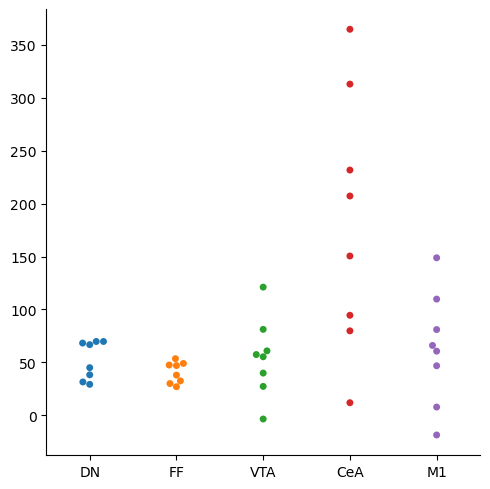

In [742]:
g = sns.catplot(data = cprpaDF, kind = "swarm")

g.ylabel = "Number Cells"

plt.show()

#different distributions by region because the potential number of recording sites per region varies?
# the weird gap in the DN data is probably because I am limiting the outcome to whole numbers

/var/folders/ct/qztxmsdn1t7gbywqlzpynx1m0000gp/T/ipykernel_63037/363523870.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=long_df, x="index", y="Value", color='red', ci='sd', capsize=0.2, join=False)
/var/folders/ct/qztxmsdn1t7gbywqlzpynx1m0000gp/T/ipykernel_63037/363523870.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=long_df, x="index", y="Value", color='red', ci='sd', capsize=0.2, join=False)


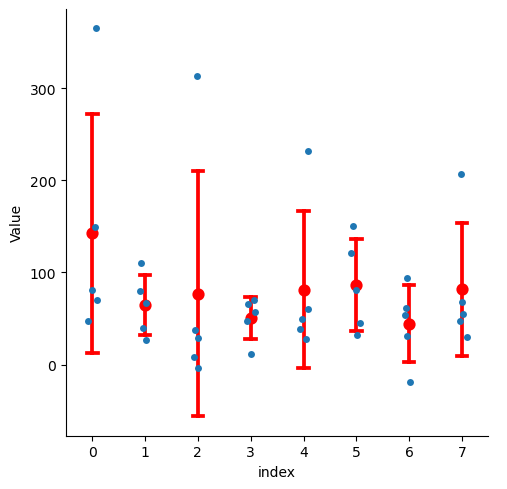

In [743]:
long_df = cprpaDF.reset_index().melt(id_vars="index", var_name="Variable", value_name="Value")

# Plot each row as an x-axis category with individual points from each row
sns.catplot(data=long_df, x="index", y="Value", kind="strip")

# Overlay the mean and standard deviation for each x-axis row index
sns.pointplot(data=long_df, x="index", y="Value", color='red', ci='sd', capsize=0.2, join=False)

# Display the plot
plt.show()

proportion that are paradigm modulated per region on average 
DN: 75% (of this, about 90% respond to running onset, and of that group 10% respond only in condition 1, and 60% respond in both conditions but respond more strongly to running onset in condition 1) 
M1: 60% (of this, 80% respond to running onset in both conditions, and 15% are responding only in condition 2) 
VTA: 70%
CeA: 70% 
FF: 50%



In [744]:
neuron_counts = dataframe_to_dict(cprpaDF_pm)

In [745]:
neuron_counts

{'DN': [70.0, 67.0, 29.0, 70.0, 38.0, 45.0, 32.0, 68.0, 39.0],
 'FF': [47.0, 27.0, 38.0, 48.0, 49.0, 32.0, 54.0, 30.0, 60.0],
 'VTA': [81.0, 40.0, 99.0, 57.0, 27.0, 121.0, 61.0, 55.0, 1.0],
 'CeA': [365.0, 80.0, 18.0, 12.0, 232.0, 150.0, 94.0, 207.0, 52.0],
 'M1': [149.0, 110.0, 44.0, 66.0, 61.0, 81.0, 112.0, 47.0, 169.0]}

In [746]:
pre_stim_points = 10
post_stim_points = 10
total_points = pre_stim_points + post_stim_points
z_score_range = (-3.5, 3.5)
#response_proportion = 0.7  # 70% of neurons respond
rois_responseprop = {"DN":0.75, "M1": 0.6, "VTA": 0.7, "CeA": 0.7, "FF":0.5}

In [747]:
list(enumerate(zip(*neuron_counts.values())))

[(0, (70.0, 47.0, 81.0, 365.0, 149.0)),
 (1, (67.0, 27.0, 40.0, 80.0, 110.0)),
 (2, (29.0, 38.0, 99.0, 18.0, 44.0)),
 (3, (70.0, 48.0, 57.0, 12.0, 66.0)),
 (4, (38.0, 49.0, 27.0, 232.0, 61.0)),
 (5, (45.0, 32.0, 121.0, 150.0, 81.0)),
 (6, (32.0, 54.0, 61.0, 94.0, 112.0)),
 (7, (68.0, 30.0, 55.0, 207.0, 47.0)),
 (8, (39.0, 60.0, 1.0, 52.0, 169.0))]

In [748]:
nested_list = list(neuron_counts.values())
flat_list = [item for sublist in nested_list for item in sublist]
sum(flat_list)

3434.0

In [749]:
all_neuron_data = []

# Generate neuron data for each animal and region
for animal_id, (dn, ff, vta, cea, m1) in enumerate(zip(*neuron_counts.values())):
    for region, num_neurons in zip(["DN", "FF", "VTA", "CeA", "M1"], [dn, ff, vta, cea, m1]):
        # Generate time series for neurons in this region
        response_proportion = rois_responseprop[region]
        time_series = generate_neuron_activity(pre_stim_points, post_stim_points, int(num_neurons), response_proportion)
        
        # Calculate peak times for each neuron in the generated time series
        peak_times = get_peak_times(time_series)
        
        # Append each neuron’s data with region, time series, and peak time
        for neuron_series, peak_time in zip(time_series, peak_times):
            all_neuron_data.append((region, neuron_series, peak_time))

# Sort all neurons by region and peak response time
all_neuron_data.sort(key=lambda x: (x[0], x[2]))  # Sort by region, then by peak_time

# Prepare data for the heatmap
sorted_time_series = []
sorted_labels = []

# Create a list of sorted time series and labels
current_region = None
for region, time_series, peak_time in all_neuron_data:
    # Only add a region label once for each group of neurons
    if region != current_region:
        sorted_labels.append(region)  # Append the region label
        current_region = region
    
    sorted_time_series.append(time_series)

# Convert list to a NumPy array for heatmap
heatmap_data = np.array(sorted_time_series)


In [750]:
len(all_neuron_data)

3434

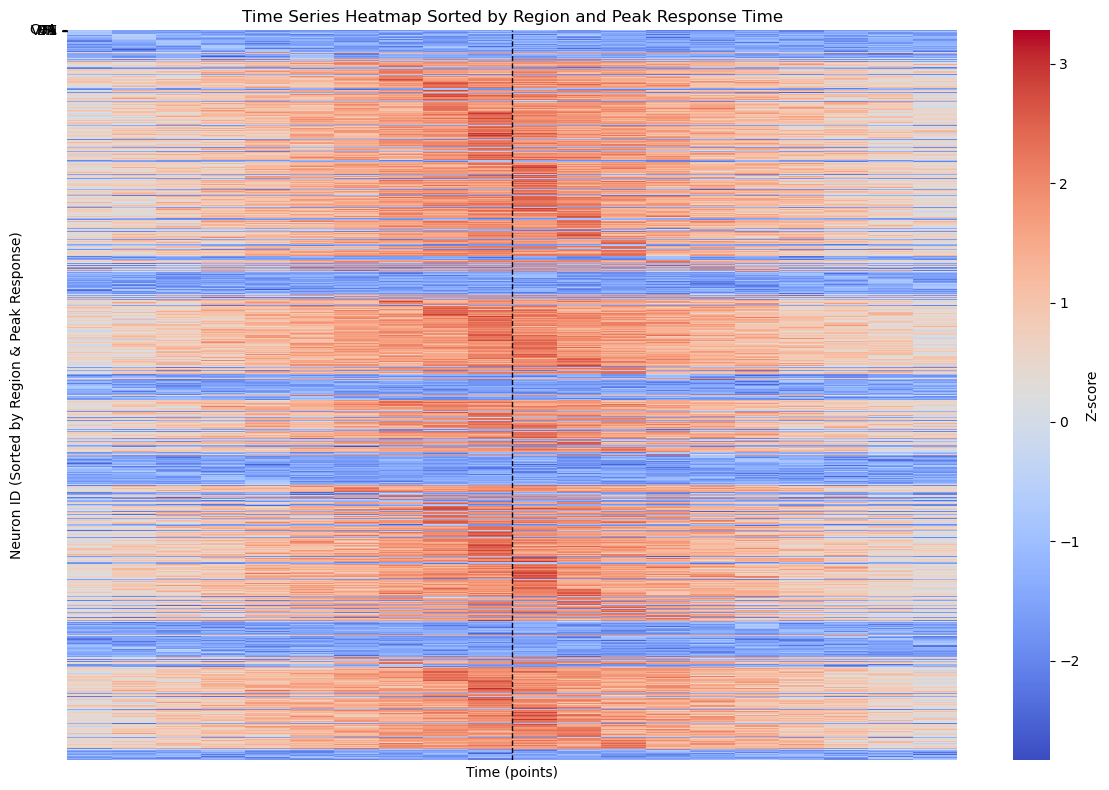

In [751]:

# Plot the heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Z-score'}, xticklabels=False, yticklabels=sorted_labels)
# Add a vertical dotted line at time point 0
plt.axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
plt.title("Time Series Heatmap Sorted by Region and Peak Response Time")
plt.xlabel("Time (points)")
plt.ylabel("Neuron ID (Sorted by Region & Peak Response)")
plt.tight_layout()
plt.show()


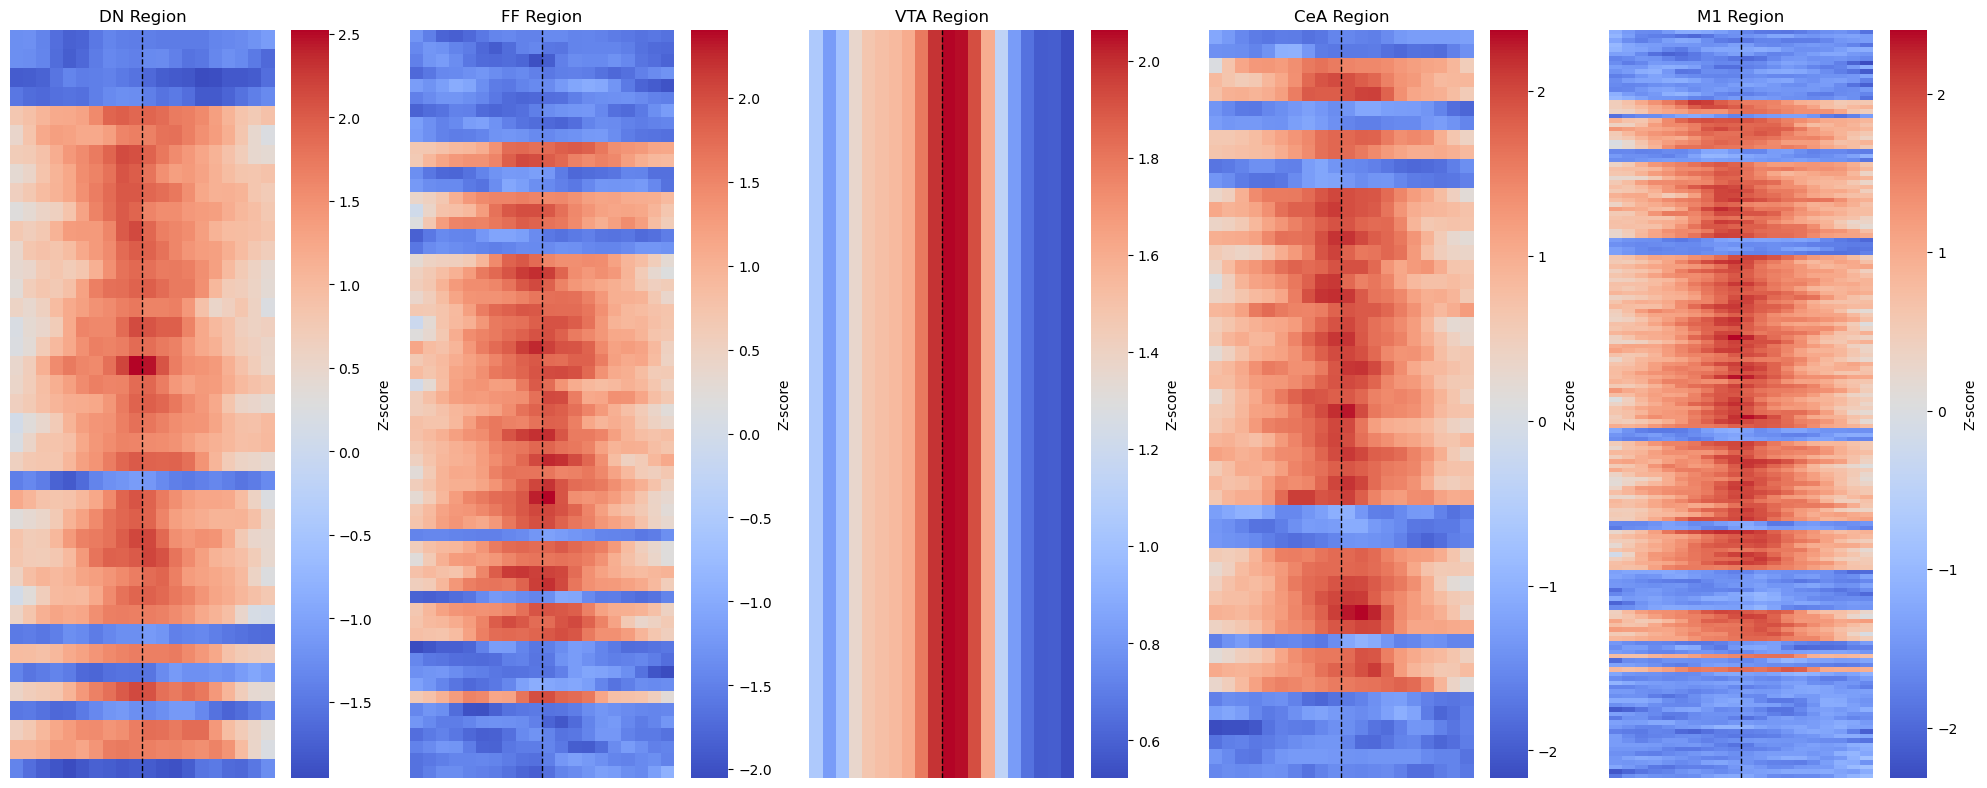

In [752]:
# Prepare data for each region
region_time_series = {region: [] for region in neuron_counts.keys()}

# Create a list of sorted time series for each region
for region, num_neurons in zip(neuron_counts.keys(), [dn, ff, vta, cea, m1]):
    region_data = []
    response_proportion = rois_responseprop[region]

    # Generate time series for all neurons in the region
    time_series_data = generate_neuron_activity(pre_stim_points, post_stim_points, int(num_neurons), response_proportion)
    
    # Calculate the peak response times for each neuron
    peak_times = get_peak_times(time_series_data)
    
    # Append each neuron’s data to region_data along with its peak time
    for neuron_series, peak_time in zip(time_series_data, peak_times):
        # Smooth the time series if necessary
        smoothed_time_series = smooth_time_series(neuron_series)
        region_data.append((smoothed_time_series, peak_time))
    
    # Sort the region data by peak time within the region
    region_data.sort(key=lambda x: x[1])  # Sort by peak_time
    
    # Extract the sorted time series
    sorted_region_time_series = [x[0] for x in region_data]
    
    # Store sorted time series by region
    region_time_series[region] = sorted_region_time_series

# Create subplots: one for each region
fig, axes = plt.subplots(nrows=1, ncols=len(region_time_series), figsize=(20, 8))

# Loop through each region and create a heatmap
for ax, (region, time_series_list) in zip(axes, region_time_series.items()):
    # Convert the list of time series for the region into a NumPy array
    heatmap_data = np.array(time_series_list)
    
    # Plot heatmap
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Z-score'}, xticklabels=False, yticklabels=False, ax=ax)
    
    # Add a vertical dotted line at time point 0 (pre-stimulus)
    ax.axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    
    # Set the title for the region
    ax.set_title(f"{region} Region")

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


In [753]:
region_time_series

{'DN': [array([-1.25307519, -1.22347434, -1.36671639, -1.59029593, -1.7443766 ,
         -1.70594668, -1.49051321, -1.35261609, -1.4180859 , -1.44820969,
         -1.41628821, -1.4596207 , -1.44925991, -1.46087731, -1.45743154,
         -1.34882424, -1.31139694, -1.28754664, -1.18580793, -1.08346055]),
  array([-1.24011886, -1.26782426, -1.35420873, -1.61419929, -1.77377403,
         -1.66267826, -1.44957538, -1.31330987, -1.36943445, -1.40299659,
         -1.30307291, -1.28150997, -1.40108718, -1.54481516, -1.50239014,
         -1.3312998 , -1.23167476, -1.29351163, -1.48220242, -1.64708755]),
  array([-1.78721969, -1.76761692, -1.71157487, -1.51924225, -1.35394559,
         -1.43969104, -1.41566888, -1.38537281, -1.47194535, -1.5493571 ,
         -1.64673664, -1.77383162, -1.80768444, -1.84526338, -1.93977647,
         -1.92652352, -1.83315775, -1.82018471, -1.79496107, -1.60586756]),
  array([-1.50718923, -1.61132392, -1.65365905, -1.57648583, -1.54464687,
         -1.57646864, -1.4

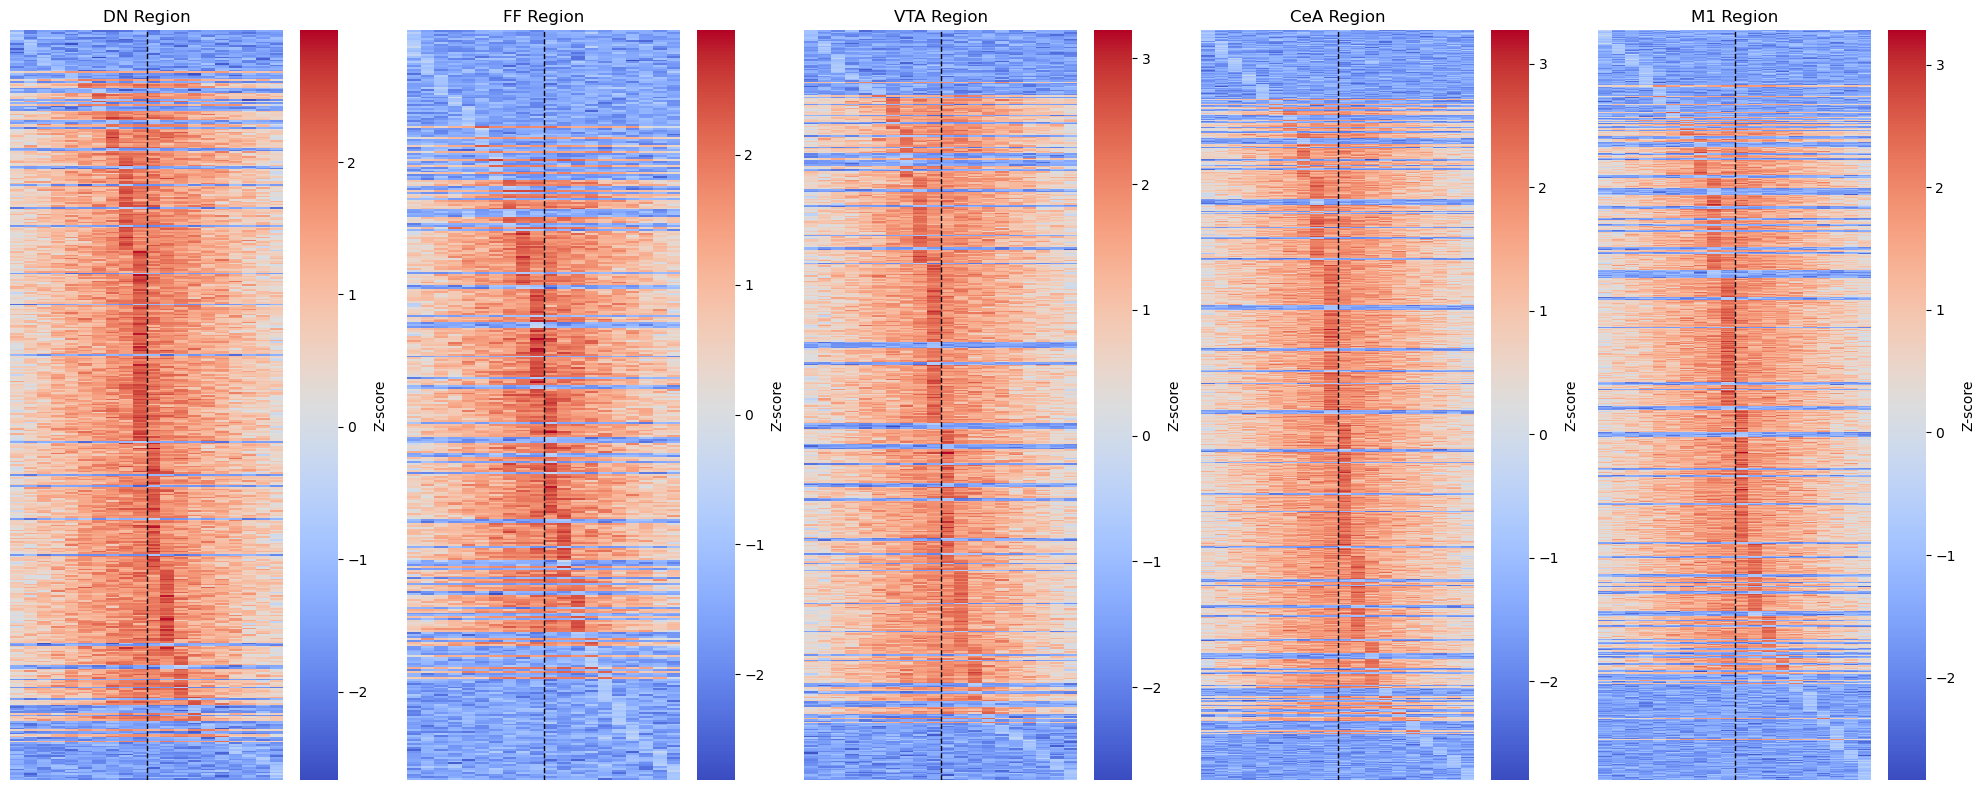

In [754]:
# Convert `all_neuron_data` from block 1 into a dictionary format organized by region
region_time_series = {region: [] for region in neuron_counts.keys()}

# Populate the region_time_series dictionary with sorted time series from `all_neuron_data`
for region, time_series, peak_time in all_neuron_data:
    # Smooth the time series if necessary
    #smoothed_time_series = smooth_time_series(time_series)
    region_time_series[region].append((time_series, peak_time))

# Sort the time series within each region by peak time
for region, data in region_time_series.items():
    # Sort by peak time
    data.sort(key=lambda x: x[1])  
    
    # Replace each entry in the region with just the smoothed time series (removing peak times)
    region_time_series[region] = [x[0] for x in data]

# Create subplots: one for each region
fig, axes = plt.subplots(nrows=1, ncols=len(region_time_series), figsize=(20, 8))

# Loop through each region and create a heatmap
for ax, (region, time_series_list) in zip(axes, region_time_series.items()):
    # Convert the list of time series for the region into a NumPy array
    heatmap_data = np.array(time_series_list)
    
    # Plot heatmap
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Z-score'}, xticklabels=False, yticklabels=False, ax=ax)
    
    # Add a vertical dotted line at time point 0 (pre-stimulus)
    ax.axvline(x=pre_stim_points, color='black', linestyle='--', linewidth=1)
    
    # Set the title for the region
    ax.set_title(f"{region} Region")

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


In [755]:
# Calculate the total number of time series across all regions
total_time_series = sum(len(time_series) for time_series in region_time_series.values())

print("Total number of time series:", total_time_series)


Total number of time series: 3434


In [689]:
# Calculate the number of time series per region
time_series_per_region = {region: len(time_series) for region, time_series in region_time_series.items()}

print("Number of time series per region:", time_series_per_region)


Number of time series per region: {'DN': 458, 'FF': 385, 'VTA': 542, 'CeA': 1210, 'M1': 839}


In [690]:
cpr

DN      458.0
FF      385.0
VTA     542.0
CeA    1210.0
M1      839.0
dtype: float64